# RBM mean field training $ L=10$  - Dataset with 25 different temperatures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import seaborn as sns

from rbm import RBM
from MC_Ising2D_MF import IsingMC

import torch
import torch.nn as nn
torch.manual_seed(12)

L = 10

## Dataset: mean field states with $ T = 10^{-6}, 0.25, 0.5, ..., 5.5, 5.75, 6 $.

The first step is to load the Mean Field Ising data generated by Monte Carlo procedure. The file `L010_Ising2D_MC_MF.pkl` was constructed based on the paper [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172). We considered a square lattice $L\times L$, with $L=10$, and generated 2000 spins configurations for each of 25 different temperatures $ T/J = 10^{-6}, 0.25, 0.5, ..., 5.5, 5.75, 6 $.

In [2]:
ising_data = pd.read_pickle('data/L010_Ising2D_MC_MF.pkl')
ising_data.head()

,energy,magn,state,temp
0,2.302761e-07,8,"[0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, ...",6.0
1,2.302761e-07,8,"[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, ...",6.0
2,-3.454141e-07,-12,"[1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, ...",6.0
3,3.454141e-07,12,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, ...",6.0
4,-1.151380e-07,-4,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, ...",6.0


In [3]:
ising_data['temp'].value_counts()

0.000001    2000
5.500000    2000
4.000000    2000
2.000000    2000
1.000000    2000
0.750000    2000
0.500000    2000
0.250000    2000
4.500000    2000
5.000000    2000
2.250000    2000
1.750000    2000
5.750000    2000
3.750000    2000
3.000000    2000
2.500000    2000
1.500000    2000
4.250000    2000
3.250000    2000
4.750000    2000
3.500000    2000
2.750000    2000
1.250000    2000
5.250000    2000
6.000000    2000
Name: temp, dtype: int64

#### Change here to the Curie-Weiss model

In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$

With the class `IsingMC` we can check some thermodynamics quantities.

Method fit will construct states to the following temperatures: 
[6.   5.78 5.56 5.34 5.12 4.9  4.68 4.46 4.24 4.02 4.01 4.   3.99 3.8
 3.58 3.36 3.14 2.92 2.7  2.48 2.26 2.04 1.82 1.6  1.38 1.16 0.94 0.72
 0.5 ]


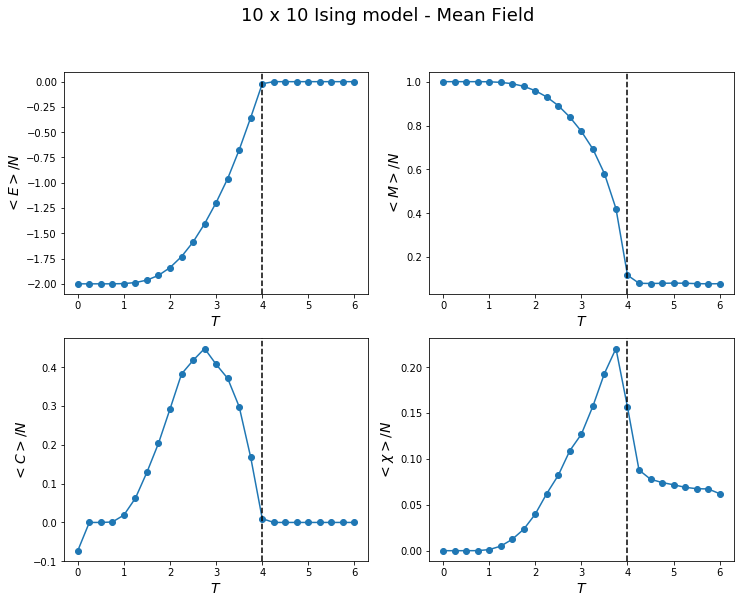

In [4]:
IsingMC(L= 10).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

In [5]:
data = ising_data.drop(columns= ['energy', 'magn'])

### Constructing training and test sets

Using `train_test_split` from [`sklearn`](http://scikit-learn.org/) it is easy to split the data into training and test sets. Since `train_test_split` is a random process and our data has 1000 samples for each of the 25 temperatures values, we split the data for each temperature in order to avoid the possibility of a biased split towards some temperature value.

In [6]:
train_data_ = pd.DataFrame()
test_data_ = pd.DataFrame()

for _, temp in enumerate(data['temp'].value_counts().index.tolist()):
    
    train_data_T, test_data_T = train_test_split(data[data['temp'] == temp],
                                                 test_size= 0.2,
                                                 random_state= 12)
    
    train_data_ = pd.concat([train_data_, train_data_T])
    test_data_ = pd.concat([test_data_, test_data_T])

### Training the model

In the work [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172) the authors have trained RBMs with the following number $N_h$ of hidden units: 16, 36, 64, 81, 100, 225 and 400. We have verified the flow towards the critical temperature for $N_h \le N_v$, where $N_v$ is the number of visible units. Since we are interested in make use of theoretical results in the thermodynamic limit, for $ N_v \rightarrow \infty$ and $ N_h \rightarrow \infty$, with $\alpha = N_h / N_v $ fixed, we show here the training for $ N_v = N_h$.

Our code implementing a Restricted Boltzmann Machine is written a python class called `RBM` which is imported from `rbm.py`.

For simplification, the units have no bias and the RBM stochasticity parameter, represented below by $T$ is set to unity, as usual in most practical applications. Note that we set `use_cuda=True`, which makes use of [CUDA tensor types](https://pytorch.org/docs/stable/cuda.html), implementing GPU computation. If a GPU is not available, one should just set `use_cuda=False`.

RBM --- Nv= 100, Nh= 100, lr= 1.0E-03, k= 1, Bsize= 100, Epochs= 12000, USE_CUDA= True, verbose= 10
Starting training
Ep 10, Rec er: 0.358473 (train), 0.356939 (test), Pseud_Lik: -43.621751, Time: 4.496046, 
Ep 20, Rec er: 0.344823 (train), 0.344435 (test), Pseud_Lik: -39.751690, Time: 4.933910, 
Ep 30, Rec er: 0.339641 (train), 0.339587 (test), Pseud_Lik: -37.380871, Time: 4.940783, 
Ep 40, Rec er: 0.336075 (train), 0.335590 (test), Pseud_Lik: -35.847265, Time: 4.510674, 
Ep 50, Rec er: 0.334605 (train), 0.333215 (test), Pseud_Lik: -34.741176, Time: 4.254622, 
Ep 60, Rec er: 0.333216 (train), 0.332575 (test), Pseud_Lik: -33.897342, Time: 4.254810, 
Ep 70, Rec er: 0.332687 (train), 0.331147 (test), Pseud_Lik: -33.318338, Time: 4.463679, 
Ep 80, Rec er: 0.332221 (train), 0.331415 (test), Pseud_Lik: -32.798538, Time: 4.630772, 
Ep 90, Rec er: 0.331274 (train), 0.331547 (test), Pseud_Lik: -32.402437, Time: 5.512656, 
Ep 100, Rec er: 0.331116 (train), 0.330763 (test), Pseud_Lik: -31.838493

Ep 900, Rec er: 0.331403 (train), 0.330737 (test), Pseud_Lik: -29.503565, Time: 4.426663, 
Ep 910, Rec er: 0.331605 (train), 0.330421 (test), Pseud_Lik: -29.540888, Time: 4.318542, 
Ep 920, Rec er: 0.331802 (train), 0.331148 (test), Pseud_Lik: -29.581488, Time: 4.037949, 
Ep 930, Rec er: 0.331799 (train), 0.330550 (test), Pseud_Lik: -29.548908, Time: 4.071045, 
Ep 940, Rec er: 0.331309 (train), 0.330735 (test), Pseud_Lik: -29.479001, Time: 4.027262, 
Ep 950, Rec er: 0.331508 (train), 0.331423 (test), Pseud_Lik: -29.498880, Time: 3.982995, 
Ep 960, Rec er: 0.331508 (train), 0.330342 (test), Pseud_Lik: -29.575734, Time: 4.018390, 
Ep 970, Rec er: 0.331648 (train), 0.331204 (test), Pseud_Lik: -29.561065, Time: 3.999204, 
Ep 980, Rec er: 0.331087 (train), 0.330971 (test), Pseud_Lik: -29.602659, Time: 3.930709, 
Ep 990, Rec er: 0.331776 (train), 0.330290 (test), Pseud_Lik: -29.523236, Time: 3.969283, 
Ep 1000, Rec er: 0.331489 (train), 0.330939 (test), Pseud_Lik: -29.511726, Time: 4.061202,

Ep 1800, Rec er: 0.329943 (train), 0.329425 (test), Pseud_Lik: -29.199846, Time: 4.124706, 
Ep 1810, Rec er: 0.330001 (train), 0.329002 (test), Pseud_Lik: -29.130127, Time: 4.107798, 
Ep 1820, Rec er: 0.329762 (train), 0.329960 (test), Pseud_Lik: -29.197727, Time: 4.219313, 
Ep 1830, Rec er: 0.329937 (train), 0.329781 (test), Pseud_Lik: -29.206946, Time: 4.159026, 
Ep 1840, Rec er: 0.329954 (train), 0.329903 (test), Pseud_Lik: -29.166376, Time: 4.090684, 
Ep 1850, Rec er: 0.329996 (train), 0.329582 (test), Pseud_Lik: -29.262633, Time: 4.022397, 
Ep 1860, Rec er: 0.329775 (train), 0.329343 (test), Pseud_Lik: -29.038895, Time: 3.988268, 
Ep 1870, Rec er: 0.329932 (train), 0.328813 (test), Pseud_Lik: -29.179946, Time: 4.027842, 
Ep 1880, Rec er: 0.329972 (train), 0.329084 (test), Pseud_Lik: -29.145471, Time: 4.001325, 
Ep 1890, Rec er: 0.329852 (train), 0.329867 (test), Pseud_Lik: -29.102162, Time: 4.029861, 
Ep 1900, Rec er: 0.330027 (train), 0.328887 (test), Pseud_Lik: -29.264140, Time:

Ep 2700, Rec er: 0.325355 (train), 0.325294 (test), Pseud_Lik: -28.969091, Time: 4.230525, 
Ep 2710, Rec er: 0.325351 (train), 0.325701 (test), Pseud_Lik: -29.015796, Time: 4.164425, 
Ep 2720, Rec er: 0.325552 (train), 0.325161 (test), Pseud_Lik: -28.969354, Time: 4.240188, 
Ep 2730, Rec er: 0.325264 (train), 0.325384 (test), Pseud_Lik: -28.863739, Time: 4.258612, 
Ep 2740, Rec er: 0.325134 (train), 0.325285 (test), Pseud_Lik: -28.908613, Time: 5.182576, 
Ep 2750, Rec er: 0.325130 (train), 0.325597 (test), Pseud_Lik: -28.917966, Time: 5.276409, 
Ep 2760, Rec er: 0.325546 (train), 0.325495 (test), Pseud_Lik: -29.020851, Time: 4.522273, 
Ep 2770, Rec er: 0.325076 (train), 0.324939 (test), Pseud_Lik: -28.924307, Time: 4.328928, 
Ep 2780, Rec er: 0.325043 (train), 0.324789 (test), Pseud_Lik: -28.953298, Time: 4.314898, 
Ep 2790, Rec er: 0.325016 (train), 0.324672 (test), Pseud_Lik: -29.061927, Time: 4.178280, 
Ep 2800, Rec er: 0.325238 (train), 0.325317 (test), Pseud_Lik: -28.987123, Time:

Ep 3600, Rec er: 0.320878 (train), 0.321733 (test), Pseud_Lik: -29.089488, Time: 4.477530, 
Ep 3610, Rec er: 0.321134 (train), 0.322010 (test), Pseud_Lik: -29.123659, Time: 4.542847, 
Ep 3620, Rec er: 0.321080 (train), 0.321819 (test), Pseud_Lik: -29.168424, Time: 4.493710, 
Ep 3630, Rec er: 0.320766 (train), 0.322100 (test), Pseud_Lik: -29.194452, Time: 4.398155, 
Ep 3640, Rec er: 0.321490 (train), 0.321384 (test), Pseud_Lik: -29.120729, Time: 4.223289, 
Ep 3650, Rec er: 0.321163 (train), 0.321125 (test), Pseud_Lik: -29.166010, Time: 4.117450, 
Ep 3660, Rec er: 0.320363 (train), 0.321035 (test), Pseud_Lik: -29.188780, Time: 5.660987, 
Ep 3670, Rec er: 0.320741 (train), 0.321597 (test), Pseud_Lik: -29.103392, Time: 4.688704, 
Ep 3680, Rec er: 0.320750 (train), 0.321090 (test), Pseud_Lik: -29.098830, Time: 4.210399, 
Ep 3690, Rec er: 0.320764 (train), 0.320142 (test), Pseud_Lik: -29.057214, Time: 4.265153, 
Ep 3700, Rec er: 0.320423 (train), 0.320873 (test), Pseud_Lik: -29.263250, Time:

Ep 4500, Rec er: 0.316411 (train), 0.317846 (test), Pseud_Lik: -29.012325, Time: 4.083785, 
Ep 4510, Rec er: 0.316747 (train), 0.317591 (test), Pseud_Lik: -29.083259, Time: 5.001655, 
Ep 4520, Rec er: 0.316707 (train), 0.317888 (test), Pseud_Lik: -28.963116, Time: 5.453075, 
Ep 4530, Rec er: 0.316601 (train), 0.317220 (test), Pseud_Lik: -29.031845, Time: 4.578397, 
Ep 4540, Rec er: 0.316428 (train), 0.317116 (test), Pseud_Lik: -29.010922, Time: 5.678852, 
Ep 4550, Rec er: 0.316592 (train), 0.317285 (test), Pseud_Lik: -29.097535, Time: 4.203923, 
Ep 4560, Rec er: 0.316624 (train), 0.317681 (test), Pseud_Lik: -28.918714, Time: 4.186483, 
Ep 4570, Rec er: 0.316268 (train), 0.316803 (test), Pseud_Lik: -29.008247, Time: 4.608255, 
Ep 4580, Rec er: 0.316697 (train), 0.317377 (test), Pseud_Lik: -28.929540, Time: 4.595571, 
Ep 4590, Rec er: 0.316357 (train), 0.316395 (test), Pseud_Lik: -28.995135, Time: 4.272234, 
Ep 4600, Rec er: 0.316119 (train), 0.317456 (test), Pseud_Lik: -29.078626, Time:

Ep 5400, Rec er: 0.312977 (train), 0.313728 (test), Pseud_Lik: -29.248338, Time: 3.874575, 
Ep 5410, Rec er: 0.313102 (train), 0.314399 (test), Pseud_Lik: -29.141742, Time: 3.871142, 
Ep 5420, Rec er: 0.313166 (train), 0.314044 (test), Pseud_Lik: -29.259196, Time: 3.849711, 
Ep 5430, Rec er: 0.313275 (train), 0.314285 (test), Pseud_Lik: -29.219167, Time: 3.863709, 
Ep 5440, Rec er: 0.313098 (train), 0.314347 (test), Pseud_Lik: -29.257353, Time: 4.115447, 
Ep 5450, Rec er: 0.313315 (train), 0.313610 (test), Pseud_Lik: -29.242408, Time: 4.600921, 
Ep 5460, Rec er: 0.313139 (train), 0.313033 (test), Pseud_Lik: -29.258253, Time: 4.715765, 
Ep 5470, Rec er: 0.312768 (train), 0.314351 (test), Pseud_Lik: -29.223245, Time: 4.545959, 
Ep 5480, Rec er: 0.313063 (train), 0.314109 (test), Pseud_Lik: -29.213699, Time: 3.967756, 
Ep 5490, Rec er: 0.312924 (train), 0.313552 (test), Pseud_Lik: -29.263917, Time: 5.175365, 
Ep 5500, Rec er: 0.312766 (train), 0.314122 (test), Pseud_Lik: -29.242401, Time:

Ep 6300, Rec er: 0.309280 (train), 0.310114 (test), Pseud_Lik: -29.411300, Time: 6.112190, 
Ep 6310, Rec er: 0.309026 (train), 0.310708 (test), Pseud_Lik: -29.273858, Time: 4.952065, 
Ep 6320, Rec er: 0.309377 (train), 0.309532 (test), Pseud_Lik: -29.517243, Time: 4.284528, 
Ep 6330, Rec er: 0.309722 (train), 0.310450 (test), Pseud_Lik: -29.449198, Time: 5.176588, 
Ep 6340, Rec er: 0.308806 (train), 0.310371 (test), Pseud_Lik: -29.404779, Time: 5.035330, 
Ep 6350, Rec er: 0.309635 (train), 0.309740 (test), Pseud_Lik: -29.455459, Time: 4.558978, 
Ep 6360, Rec er: 0.308697 (train), 0.310201 (test), Pseud_Lik: -29.444617, Time: 4.346973, 
Ep 6370, Rec er: 0.308548 (train), 0.310128 (test), Pseud_Lik: -29.293879, Time: 6.206801, 
Ep 6380, Rec er: 0.308570 (train), 0.310536 (test), Pseud_Lik: -29.404046, Time: 5.725270, 
Ep 6390, Rec er: 0.308690 (train), 0.310462 (test), Pseud_Lik: -29.472858, Time: 5.346388, 
Ep 6400, Rec er: 0.309257 (train), 0.309317 (test), Pseud_Lik: -29.488364, Time:

Ep 7200, Rec er: 0.306073 (train), 0.307280 (test), Pseud_Lik: -29.621251, Time: 5.979503, 
Ep 7210, Rec er: 0.305960 (train), 0.306328 (test), Pseud_Lik: -29.553254, Time: 4.890686, 
Ep 7220, Rec er: 0.305720 (train), 0.306924 (test), Pseud_Lik: -29.565986, Time: 4.398443, 
Ep 7230, Rec er: 0.305720 (train), 0.307275 (test), Pseud_Lik: -29.571216, Time: 4.768285, 
Ep 7240, Rec er: 0.305808 (train), 0.306950 (test), Pseud_Lik: -29.540724, Time: 5.539579, 
Ep 7250, Rec er: 0.305895 (train), 0.307902 (test), Pseud_Lik: -29.572067, Time: 4.485501, 
Ep 7260, Rec er: 0.305885 (train), 0.306303 (test), Pseud_Lik: -29.599583, Time: 4.357218, 
Ep 7270, Rec er: 0.306008 (train), 0.307673 (test), Pseud_Lik: -29.470284, Time: 4.434043, 
Ep 7280, Rec er: 0.306015 (train), 0.307551 (test), Pseud_Lik: -29.725221, Time: 4.149956, 
Ep 7290, Rec er: 0.305701 (train), 0.306977 (test), Pseud_Lik: -29.688521, Time: 4.194402, 
Ep 7300, Rec er: 0.305787 (train), 0.306555 (test), Pseud_Lik: -29.669077, Time:

Ep 8100, Rec er: 0.304756 (train), 0.305613 (test), Pseud_Lik: -30.352690, Time: 4.534180, 
Ep 8110, Rec er: 0.304273 (train), 0.305352 (test), Pseud_Lik: -30.279922, Time: 4.574826, 
Ep 8120, Rec er: 0.304595 (train), 0.306422 (test), Pseud_Lik: -30.186492, Time: 4.563874, 
Ep 8130, Rec er: 0.304670 (train), 0.305784 (test), Pseud_Lik: -30.079958, Time: 4.462025, 
Ep 8140, Rec er: 0.304908 (train), 0.305390 (test), Pseud_Lik: -30.191628, Time: 4.130203, 
Ep 8150, Rec er: 0.303933 (train), 0.306426 (test), Pseud_Lik: -30.177742, Time: 4.132430, 
Ep 8160, Rec er: 0.304892 (train), 0.305354 (test), Pseud_Lik: -30.196898, Time: 4.213003, 
Ep 8170, Rec er: 0.304303 (train), 0.306660 (test), Pseud_Lik: -30.300703, Time: 4.126110, 
Ep 8180, Rec er: 0.304858 (train), 0.305091 (test), Pseud_Lik: -30.213072, Time: 4.288183, 
Ep 8190, Rec er: 0.304619 (train), 0.305455 (test), Pseud_Lik: -30.267493, Time: 4.109686, 
Ep 8200, Rec er: 0.304382 (train), 0.305956 (test), Pseud_Lik: -30.180530, Time:

Ep 9000, Rec er: 0.303396 (train), 0.304070 (test), Pseud_Lik: -30.508795, Time: 4.340873, 
Ep 9010, Rec er: 0.302882 (train), 0.304710 (test), Pseud_Lik: -30.358197, Time: 4.276115, 
Ep 9020, Rec er: 0.303126 (train), 0.304647 (test), Pseud_Lik: -30.597625, Time: 4.246926, 
Ep 9030, Rec er: 0.303298 (train), 0.305235 (test), Pseud_Lik: -30.279145, Time: 4.489269, 
Ep 9040, Rec er: 0.303148 (train), 0.304376 (test), Pseud_Lik: -30.322546, Time: 4.553229, 
Ep 9050, Rec er: 0.303475 (train), 0.304378 (test), Pseud_Lik: -30.112112, Time: 4.493935, 
Ep 9060, Rec er: 0.302840 (train), 0.304150 (test), Pseud_Lik: -30.240023, Time: 4.920357, 
Ep 9070, Rec er: 0.303437 (train), 0.303835 (test), Pseud_Lik: -30.439938, Time: 4.536704, 
Ep 9080, Rec er: 0.302810 (train), 0.305324 (test), Pseud_Lik: -30.296839, Time: 4.573702, 
Ep 9090, Rec er: 0.303400 (train), 0.304736 (test), Pseud_Lik: -30.173671, Time: 5.182409, 
Ep 9100, Rec er: 0.303542 (train), 0.303590 (test), Pseud_Lik: -30.425779, Time:

Ep 9900, Rec er: 0.302245 (train), 0.303876 (test), Pseud_Lik: -30.540134, Time: 4.773662, 
Ep 9910, Rec er: 0.302238 (train), 0.303032 (test), Pseud_Lik: -30.515812, Time: 4.325000, 
Ep 9920, Rec er: 0.301907 (train), 0.303365 (test), Pseud_Lik: -30.387096, Time: 4.262646, 
Ep 9930, Rec er: 0.302011 (train), 0.303247 (test), Pseud_Lik: -30.508100, Time: 4.166771, 
Ep 9940, Rec er: 0.302022 (train), 0.303042 (test), Pseud_Lik: -30.562690, Time: 4.277050, 
Ep 9950, Rec er: 0.302270 (train), 0.303329 (test), Pseud_Lik: -30.682500, Time: 4.136310, 
Ep 9960, Rec er: 0.302070 (train), 0.303788 (test), Pseud_Lik: -30.541148, Time: 4.090031, 
Ep 9970, Rec er: 0.302389 (train), 0.303650 (test), Pseud_Lik: -30.533097, Time: 4.151443, 
Ep 9980, Rec er: 0.302251 (train), 0.303636 (test), Pseud_Lik: -30.420306, Time: 4.088989, 
Ep 9990, Rec er: 0.301992 (train), 0.303192 (test), Pseud_Lik: -30.329262, Time: 4.138395, 
Ep 10000, Rec er: 0.301972 (train), 0.302884 (test), Pseud_Lik: -30.605077, Time

Ep 10790, Rec er: 0.301424 (train), 0.302162 (test), Pseud_Lik: -31.038605, Time: 4.264794, 
Ep 10800, Rec er: 0.301226 (train), 0.302681 (test), Pseud_Lik: -30.852176, Time: 4.344995, 
Ep 10810, Rec er: 0.301408 (train), 0.303416 (test), Pseud_Lik: -30.796586, Time: 4.300293, 
Ep 10820, Rec er: 0.301424 (train), 0.302874 (test), Pseud_Lik: -31.033640, Time: 4.069971, 
Ep 10830, Rec er: 0.301070 (train), 0.302531 (test), Pseud_Lik: -30.886952, Time: 4.159803, 
Ep 10840, Rec er: 0.301746 (train), 0.302508 (test), Pseud_Lik: -30.811294, Time: 4.731827, 
Ep 10850, Rec er: 0.301324 (train), 0.303608 (test), Pseud_Lik: -30.813361, Time: 4.388001, 
Ep 10860, Rec er: 0.301254 (train), 0.303221 (test), Pseud_Lik: -30.630778, Time: 4.156461, 
Ep 10870, Rec er: 0.301336 (train), 0.302728 (test), Pseud_Lik: -30.818237, Time: 4.460460, 
Ep 10880, Rec er: 0.301115 (train), 0.302006 (test), Pseud_Lik: -30.760037, Time: 5.234045, 
Ep 10890, Rec er: 0.301674 (train), 0.302423 (test), Pseud_Lik: -31.03

Ep 11680, Rec er: 0.300440 (train), 0.302160 (test), Pseud_Lik: -31.010285, Time: 4.430174, 
Ep 11690, Rec er: 0.301049 (train), 0.302658 (test), Pseud_Lik: -31.185615, Time: 4.278835, 
Ep 11700, Rec er: 0.300473 (train), 0.302024 (test), Pseud_Lik: -30.967627, Time: 4.304468, 
Ep 11710, Rec er: 0.300906 (train), 0.301726 (test), Pseud_Lik: -30.995171, Time: 4.328038, 
Ep 11720, Rec er: 0.300610 (train), 0.302632 (test), Pseud_Lik: -30.842004, Time: 5.134168, 
Ep 11730, Rec er: 0.300609 (train), 0.302299 (test), Pseud_Lik: -30.675029, Time: 4.776526, 
Ep 11740, Rec er: 0.300352 (train), 0.302513 (test), Pseud_Lik: -31.249644, Time: 5.487272, 
Ep 11750, Rec er: 0.300702 (train), 0.302091 (test), Pseud_Lik: -31.029077, Time: 4.230598, 
Ep 11760, Rec er: 0.300871 (train), 0.301605 (test), Pseud_Lik: -31.018682, Time: 4.601565, 
Ep 11770, Rec er: 0.300219 (train), 0.303024 (test), Pseud_Lik: -31.472257, Time: 5.164700, 
Ep 11780, Rec er: 0.300412 (train), 0.302798 (test), Pseud_Lik: -30.94

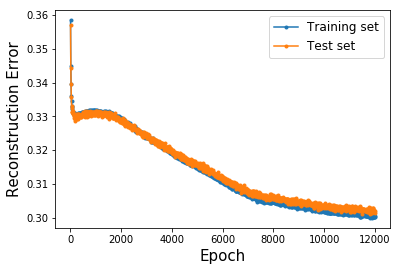

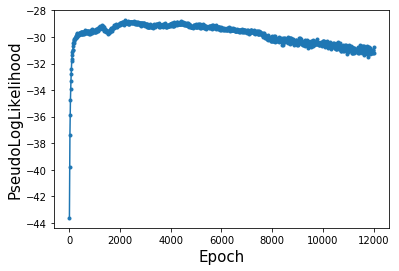

In [8]:
training_set = torch.Tensor(list(train_data_['state']))
training_set = training_set[torch.randperm(training_set.size()[0])]

test_set = torch.Tensor(list(test_data_['state']))


lr = 0.001
k_learning = 1
batch_size = 100
nb_epoch = 12000
k_sampling = 1

rbm = RBM(num_visible= training_set.shape[1], 
          num_hidden= training_set.shape[1], 
          bias= False,
          T= 1.0,
          use_cuda= True)
    
rbm.learn(training_set= training_set, 
          test_set= test_set,
          lr= lr, 
          nb_epoch= nb_epoch, 
          batch_size= batch_size,
          k_learning= k_learning,
          k_sampling = k_sampling,
          verbose= 10)

### Saving the trained model

In [ ]:
nb_epoch= rbm.num_train_epochs()
Nv= training_set.shape[1]
Nh= training_set.shape[1]

name = 'RBM_model_T_complete_nv%d_nh%d_lr%.1E_k%d_bsize%d_nepochs%d' % (Nv,
                                                                        Nh,
                                                                        lr,
                                                                        k_learning,
                                                                        batch_size,
                                                                        nb_epoch)

PATH = 'RBM_trained_models/'+ name + '.pt'

torch.save(rbm, PATH)

### Weights distribution

In [11]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

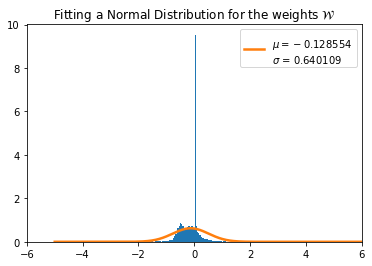

In [12]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 1000, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_, sigmaW_ = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_, sigmaW_) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_, sigmaW_ ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.xlim([-6, 6])
plt.legend()
plt.show()

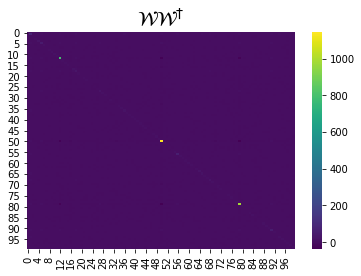

In [13]:
WW = torch.mm(W.t(), W)
sns.heatmap(WW, linewidths= 0.0, cmap= 'viridis')
plt.title('${\cal W} {\cal W}^{\dag}$', fontsize= 20)
plt.show()